In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats 

import warnings
warnings.filterwarnings('ignore')

In [7]:
# Read the data
df_java = pd.read_csv('results_java.csv')
df_c = pd.read_csv('results_c.csv')
df_c['language'] = 'c'
# Combine datasets
df = pd.concat([df_java, df_c], ignore_index=True)

# overall

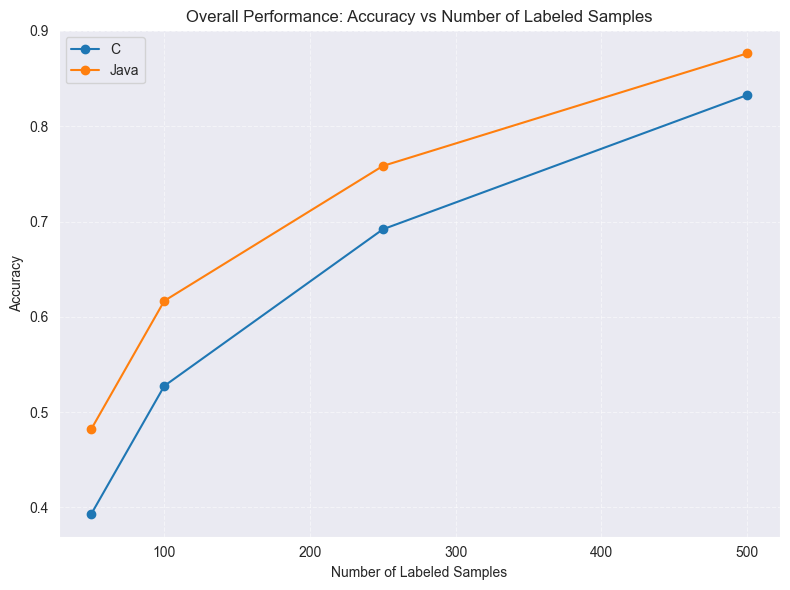

In [15]:
accuracy_summary = df.groupby(['labeled', 'language'])['accuracy'].mean().reset_index()

import matplotlib.pyplot as plt

# Plot overall performance
plt.figure(figsize=(8,6))
for lang in accuracy_summary['language'].unique():
    subset = accuracy_summary[accuracy_summary['language'] == lang]
    plt.plot(subset['labeled'], subset['accuracy'], marker='o', label=lang.capitalize())

plt.title('Overall Performance: Accuracy vs Number of Labeled Samples')
plt.xlabel('Number of Labeled Samples')
plt.ylabel('Accuracy')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()

# Save the plot as a PNG file
plt.savefig('overall_performance.png', dpi=300)  # dpi=300 for high quality
plt.show()

# Cross-Language Analysis

In [9]:
def calculate_performance_gaps(df):
    """Calculate performance gaps between Java and C for each combination"""
    group_cols = ['embedding', 'strategy', 'labeled', 'func']
    metrics = ['accuracy', 'ari', 'nmi', 'f1', 'recall']
    
    # Pivot to have Java and C as columns
    pivot_df = df.pivot_table(
        index=group_cols, 
        columns='language', 
        values=metrics,
        aggfunc='mean'
    )
    
    # Calculate differences
    for metric in metrics:
        pivot_df[(metric, 'delta')] = pivot_df[(metric, 'java')] - pivot_df[(metric, 'c')]
        pivot_df[(metric, 'relative_diff')] = (
            (pivot_df[(metric, 'java')] - pivot_df[(metric, 'c')]) / pivot_df[(metric, 'c')] * 100
        )
    
    return pivot_df

def analyze_gaps(pivot_df):
    """Summarize mean gap and counts of Java > C"""
    metrics = ['accuracy', 'ari', 'nmi', 'f1', 'recall']
    results = []

    for metric in metrics:
        delta = pivot_df[(metric, 'delta')].dropna()
        mean_diff = delta.mean()
        java_better = (delta >= 0).sum()
        c_better = (delta < 0).sum()
        java_better_pct = java_better/(java_better + c_better) * 100
        results.append([metric, mean_diff, java_better, c_better, java_better_pct, len(delta)])
    
    summary_df = pd.DataFrame(results, columns=[
        "metric", "mean_diff", "java_better", "c_better", "equal", "total_cases"
    ])
    return summary_df

def plot_gaps(pivot_df, save_path="java_c_gaps.png"):
    """Boxplot of deltas and save to file"""
    metrics = ['accuracy', 'ari', 'nmi', 'f1', 'recall']
    data = [pivot_df[(metric, 'delta')].dropna() for metric in metrics]

    plt.figure(figsize=(8,5))
    plt.boxplot(data, labels=metrics)
    plt.axhline(0, color='red', linestyle='--', linewidth=1)
    plt.title("Java - C Performance Gaps")
    plt.ylabel("Difference (Java - C)")
    plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.close()


# === Example usage ===
performance_gaps = calculate_performance_gaps(df)
summary = analyze_gaps(performance_gaps)
print(summary)

plot_gaps(performance_gaps, "gap_boxplot.png")

     metric  mean_diff  java_better  c_better  equal  total_cases
0  accuracy   0.072135          199         1   99.5          200
1       ari   0.091399          199         1   99.5          200
2       nmi   0.088712          200         0  100.0          200
3        f1   0.066050          192         8   96.0          200
4    recall   0.066690          193         7   96.5          200


# Approach Difference

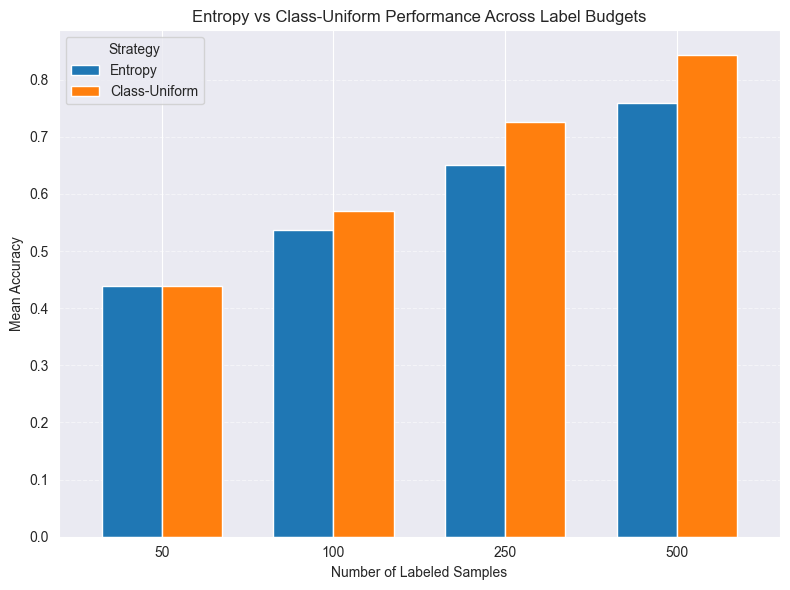

In [16]:
# 1 
df_compare = df[df['strategy'].isin(['entropy', 'uniform'])]

# Group by label budget + strategy and compute mean accuracy
summary = (
    df_compare.groupby(['labeled', 'strategy'])['accuracy']
    .mean()
    .reset_index()
)

# Pivot for easier plotting
pivot_df = summary.pivot(index='labeled', columns='strategy', values='accuracy')

# Plot as bar chart
ax = pivot_df.plot(kind='bar', figsize=(8,6), width=0.7)

plt.title("Entropy vs Class-Uniform Performance Across Label Budgets")
plt.xlabel("Number of Labeled Samples")
plt.ylabel("Mean Accuracy")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend(title="Strategy", labels=["Entropy", "Class-Uniform"])
plt.tight_layout()

# Save figure
plt.savefig("entropy_vs_uniform.png", dpi=300)
plt.show()

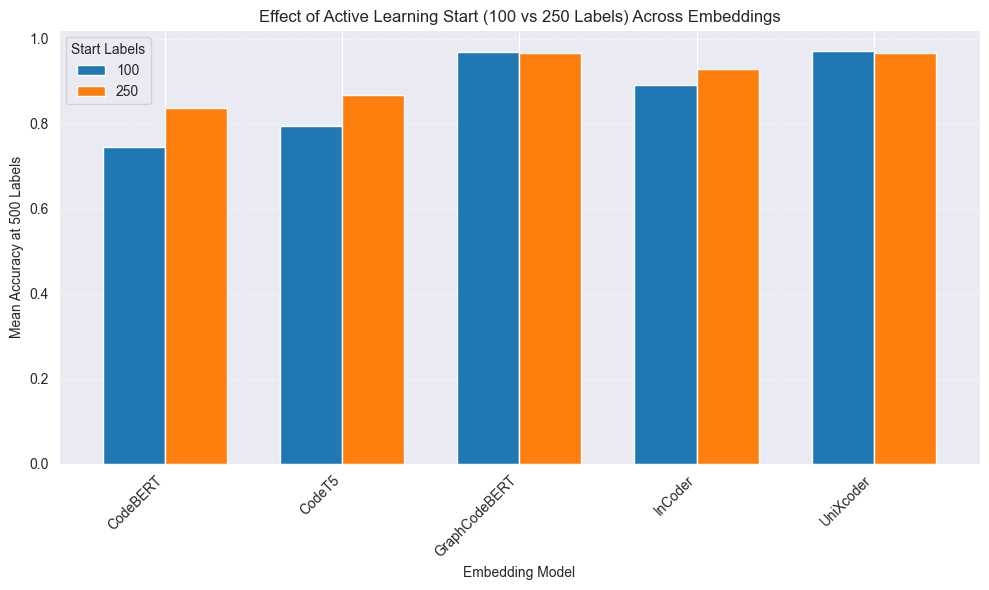

In [21]:
# 2
import pandas as pd
import matplotlib.pyplot as plt

# Map strategies to start_labels
mapping = {
    "random_then_entropy_1": 100,
    "random_then_entropy_2": 250
}

df_start = df[df['strategy'].isin(mapping.keys())].copy()
df_start['start_labels'] = df_start['strategy'].map(mapping)

# Focus only on evaluation at 500 labels
df_500 = df_start[df_start['labeled'] == 500].copy()

# Normalize strategy name for grouping
df_500['base_strategy'] = 'random→entropy'

# Group by embedding (model) + start_labels
summary = (
    df_500.groupby(['embedding', 'start_labels'])['accuracy']
    .mean()
    .reset_index()
)

# Pivot for grouped bar chart
pivot_df = summary.pivot(index='embedding', columns='start_labels', values='accuracy')

# Plot grouped bars (one group per embedding)
ax = pivot_df.plot(kind='bar', figsize=(10,6), width=0.7)

plt.title("Effect of Active Learning Start (100 vs 250 Labels) Across Embeddings")
plt.xlabel("Embedding Model")
plt.ylabel("Mean Accuracy at 500 Labels")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend(title="Start Labels")
plt.tight_layout()

# Save figure
plt.savefig("al_start_100_vs_250_by_embedding.png", dpi=300)
plt.show()

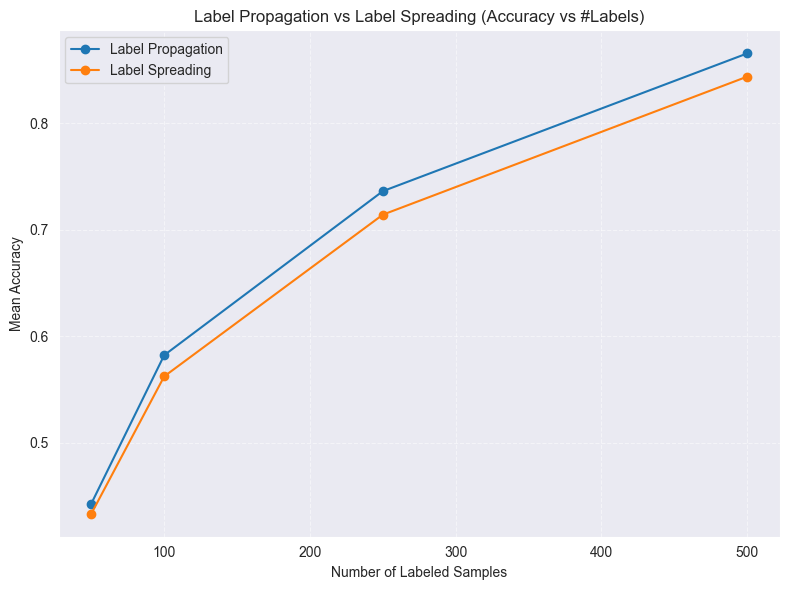

In [22]:
# 3
import pandas as pd
import matplotlib.pyplot as plt

# Filter only Label Propagation vs Label Spreading
df_compare = df[df['func'].isin(['label_propagation', 'label_spreading'])]

# Group by method + labeled samples (average over embeddings/strategies if needed)
summary = (
    df_compare.groupby(['func', 'labeled'])['accuracy']
    .mean()
    .reset_index()
)

# Plot curves
plt.figure(figsize=(8,6))
for method in summary['func'].unique():
    subset = summary[summary['func'] == method]
    plt.plot(subset['labeled'], subset['accuracy'], marker='o', label=method.replace('_', ' ').title())

plt.title("Label Propagation vs Label Spreading (Accuracy vs #Labels)")
plt.xlabel("Number of Labeled Samples")
plt.ylabel("Mean Accuracy")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()

# Save figure
plt.savefig("propagation_vs_spreading.png", dpi=300)
plt.show()


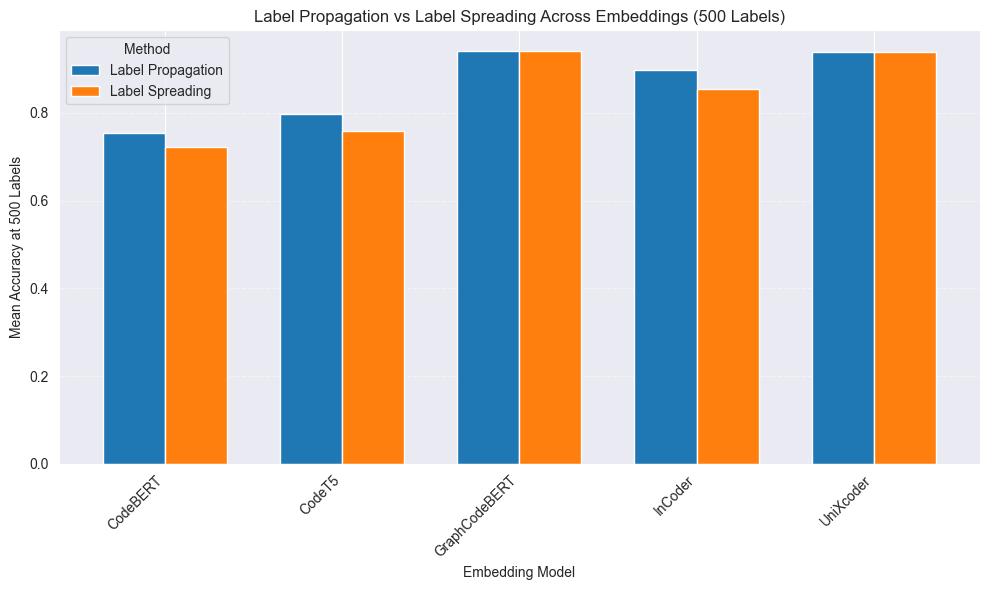

In [23]:
df_500 = df_compare[df_compare['labeled'] == 500]

bar_summary = (
    df_500.groupby(['embedding', 'func'])['accuracy']
    .mean()
    .reset_index()
)

pivot_df = bar_summary.pivot(index='embedding', columns='func', values='accuracy')

ax = pivot_df.plot(kind='bar', figsize=(10,6), width=0.7)

plt.title("Label Propagation vs Label Spreading Across Embeddings (500 Labels)")
plt.xlabel("Embedding Model")
plt.ylabel("Mean Accuracy at 500 Labels")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend(title="Method", labels=["Label Propagation", "Label Spreading"])
plt.tight_layout()
plt.savefig("propagation_vs_spreading_embeddings.png", dpi=300)
plt.show()

In [26]:
# 4
strategies_of_interest = ['random', 'entropy']
df_table = df[df['strategy'].isin(strategies_of_interest)].copy()

# Group by embedding + strategy + label budget and compute mean accuracy
summary = (
    df_table.groupby(['embedding', 'strategy', 'labeled'])['accuracy']
    .mean()
    .reset_index()
)

# Pivot to make a readable table: one row per embedding per label budget
pivot_table = summary.pivot_table(
    index=['embedding', 'labeled'],
    columns='strategy',
    values='accuracy'
).reset_index()

# Add column for difference: entropy minus random
pivot_table['entropy_minus_random'] = pivot_table['entropy'] - pivot_table['random']

# Optional: round for readability
pivot_table = pivot_table.round(3)

# Display table
print(pivot_table)

strategy      embedding  labeled  entropy  random  entropy_minus_random
0              CodeBERT       50    0.442   0.442                 0.000
1              CodeBERT      100    0.488   0.588                -0.100
2              CodeBERT      250    0.506   0.755                -0.248
3              CodeBERT      500    0.543   0.885                -0.342
4                CodeT5       50    0.504   0.504                 0.000
5                CodeT5      100    0.513   0.648                -0.135
6                CodeT5      250    0.534   0.798                -0.264
7                CodeT5      500    0.582   0.911                -0.329
8         GraphCodeBERT       50    0.307   0.307                 0.000
9         GraphCodeBERT      100    0.516   0.471                 0.045
10        GraphCodeBERT      250    0.778   0.666                 0.112
11        GraphCodeBERT      500    0.959   0.841                 0.118
12              InCoder       50    0.648   0.648               